# Обучение модели энкодера

Для ранжирования и отбора кандидатов обучу модель энкодера на основе библиотеки sentence transformers

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sentence_transformers.readers import InputExample
from sentence_transformers import SentenceTransformer, models, losses, evaluation


In [2]:
model_name = "distilroberta-base"
max_seq_length = 128
num_epochs = 1
train_batch_size = 8

Архитектура модели:

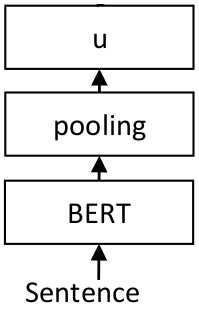

Case 4: When your samples are triplets of the form [anchor, positive, negative], you should use TripletLoss. This loss minimizes the distance between the anchor and the positive sentences while maximizing the distance between the anchor and the negative sentences.

In [3]:
## Собираем модель:
word_embedding_model = models.Transformer(model_name, max_seq_length=max_seq_length)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Загружаем данные, которые уже обработаны до триплетов:
- ancor - комбинация контекста и вопросв
- positive - ответ на вопрос из скрипта
- negative - случайно подобранный ответ


In [4]:
data = pd.read_pickle("data/scripts_for_biencoder.pkl")
data.head(3)

,question,context,answer,label,neg_answer,combined
0,Rising rapidly.,"No, but I’m also closer to the entrance in ca...","Now, this side offers me proximity to the bath...",1,"Well, that's the real trick, isn't it? And it...","No, but I’m also closer to the entrance in ca..."
1,"Okay, look. Instead of trying to reinforce th...",You don’t really believe in that superstition...,It won’ t work. The diameter of the tubing is ...,1,"Yeah. No one can hide from me, not Waldo, not...",You don’t really believe in that superstition...
2,Sheldon!,Are you implying that my girlfriend has no se...,What? That was ambiguous.,1,"Oh, damn, they cancelled my Visa. Oh, yay, a ...",Are you implying that my girlfriend has no se...


In [5]:
examples = []

for index, row in data.iterrows():
    examples.append(InputExample(texts=[row["combined"], row["answer"], row['neg_answer']]))
train_examples, valid_examples = train_test_split(examples, test_size=0.2)

In [6]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=train_batch_size)
valid_dataloader = DataLoader(valid_examples, shuffle=False, batch_size=train_batch_size)

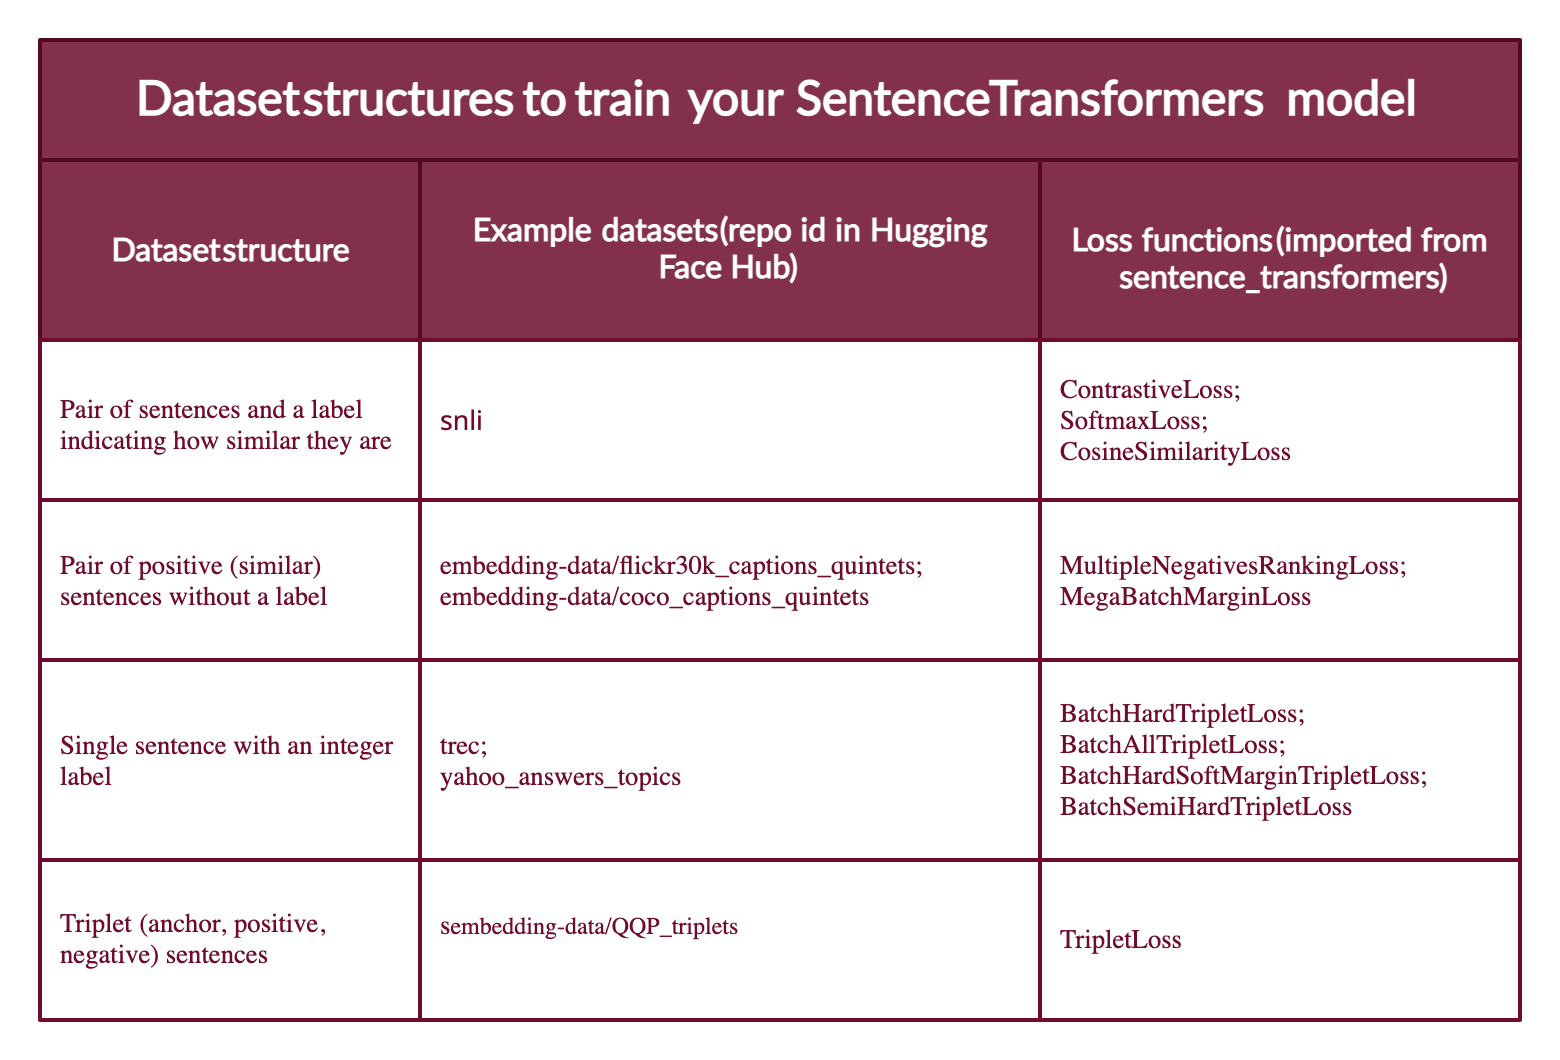

TripletEvaluator checks if distance(sentence, positive_example) < distance(sentence, negative_example).

In [7]:
train_loss = losses.TripletLoss(model=model)

In [8]:
dev_evaluator = evaluation.TripletEvaluator.from_input_examples(train_examples,
                                                                name = 'dev_evaluator',
                                                                batch_size=8, 
                                                                write_csv=True)

In [9]:
model.evaluate(dev_evaluator)

0.6577196604725855

In [10]:
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of train data

In [11]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=dev_evaluator,
    evaluation_steps=300,
    output_path='./sbert_test'
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1090 [00:00<?, ?it/s]

In [12]:
val_evaluator = evaluation.TripletEvaluator.from_input_examples(
    valid_examples, name="Valid", batch_size=8, write_csv=True,
)

model.evaluate(val_evaluator)

0.9426605504587156

In [15]:
from huggingface_hub import notebook_login

notebook_login()

In [20]:
model.save_to_hub(
    "Shakhovak/chatbot_sentence-transformer",
)

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

'https://huggingface.co/Shakhovak/chatbot_sentence-transformer/commit/765f52d480654b63e1740cd65007e2faf5f70dba'